# 07_model_descriptive_statistics

## Build model and generate data

In [ ]:
import numpy as np
import pyopencl as cl
import nengo
import nengo_ocl
from srnn_pfc.lmu import make_lmu_dms


In [ ]:
srate = 1000
model_kwargs = {
    'n_trials_per_cond': 2,
    'seed': 1337,  # ensemble seed
    'trial_seed': 1337,
    'out_transform': None,
    'q': 6,
    'theta': 7.0,
    'tau': 0.2,  # Ignored if hetero_tau is True
    'n_neurons': 1200,
    'max_rates': ['default', 'uniform_low', 'data'][0],
    'dales_law': False,
    'hetero_tau': False,
    'ssp_dim': 0
}

# cl context
cl_plat = [_ for _ in cl.get_platforms() if _.vendor.upper().startswith('NVIDIA')][0]
cl_ctx = cl.Context(dev_type=cl.device_type.ALL,
                    properties=[(cl.context_properties.PLATFORM, cl_plat)])

# Generate training data
model, probes = make_lmu_dms(**model_kwargs)
n_train_trials = model_kwargs['n_trials_per_cond'] * 8 * 2  # 16 conditions
with nengo_ocl.Simulator(model, context=cl_ctx) as sim:
    sim.run(6 * n_train_trials)  # 6 seconds per trial
    
#filt = nengo.synapses.Lowpass(0.01)
filt = nengo.Alpha(0.05)
spikes = sim.data[probes['ensemble']]
rates = filt.filt(spikes)
tvec = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/chad/miniconda3/envs/srnn_pfc/lib/python3.7/site-packages/nengo/neurons.py:438: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Take a look at the spiketrains.

<AxesSubplot:>

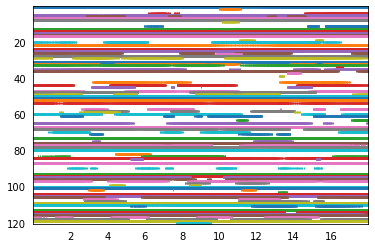

In [ ]:
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import sorted_neurons, tuning_curves


sort_idx = sorted_neurons(model.ensembles[0], sim)
rasterplot(tvec[tvec < 18], spikes[:, sort_idx][tvec < 18, ::10])

## Calculate statistics of ensemble spiking

In [ ]:
import quantities as pq
from neo.core import SpikeTrain
from elephant.statistics import isi, cv, mean_firing_rate
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import spike_train_timescale
from pingouin import circ_corrcl


bin_size = 1 * pq.ms
max_tau = 500 * pq.ms
t_stop = (tvec[-1] + 0.001) * pq.s 
n_neur = model_kwargs['n_neurons']

cv_out = np.nan * np.ones((n_neur, 1))
rate_out = np.nan * np.ones((n_neur, 1))
tscale_out = np.nan * np.ones((n_neur, 1))

for n_ix in range(n_neur):
    spike_inds = np.where(spikes[:, n_ix])[0]
    if len(spike_inds) > 1:
        spike_times = tvec[spike_inds]
        spiketrain = SpikeTrain(spike_times * pq.s, t_stop)
        bin_spiketrain = BinnedSpikeTrain(spiketrain, bin_size=bin_size, t_stop=t_stop, tolerance=None)

        cv_out[n_ix] = cv(isi(spiketrain))
        rate_out[n_ix] = mean_firing_rate(spiketrain)
        tscale_out[n_ix] = spike_train_timescale(bin_spiketrain, max_tau).rescale(pq.s).magnitude


#### Distribution of CVs

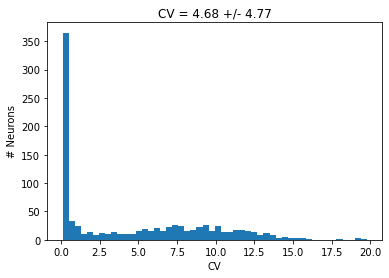

In [ ]:
tmp = cv_out[np.logical_and(~np.isnan(cv_out), cv_out > 0.1)]
plt.hist(tmp, bins=50)
plt.xlabel('CV')
plt.ylabel('# Neurons')
plt.title(f"CV = {np.nanmean(tmp):.2f} +/- {np.nanstd(tmp):.2f}")
plt.show()

#### Distribution of firing rates. (Note the log-scale in the plot.)

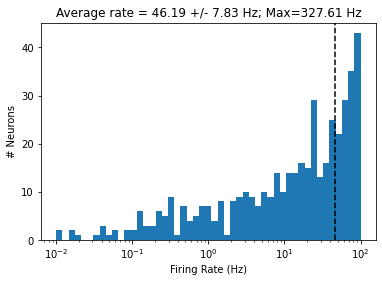

In [ ]:
avg_rate, sigma_rate = 10**np.nanmean(np.log10(rate_out)), 10**np.nanstd(np.log10(rate_out))

plt.hist(rate_out, bins=10 ** np.linspace(np.log10(0.01), np.log10(100), 50))
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('# Neurons')
plt.gca().set_xscale("log")
plt.axvline(avg_rate, ls='--', color='k')
plt.title(f"Average rate = {avg_rate:.2f} +/- {sigma_rate:.2f} Hz; Max={np.nanmax(rate_out):.2f} Hz")
plt.show()

#### Distribution of correlation timescales

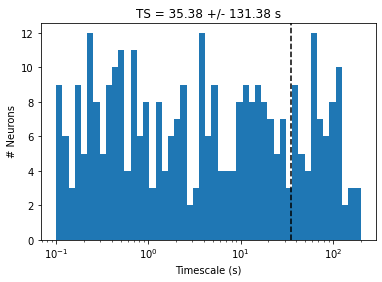

In [ ]:
tmp = np.sort(tscale_out[~np.isnan(tscale_out)])[::-1]
tmp = tmp[int(0.1 * tmp.size):int(0.9*tmp.size)]
plt.hist(tmp, bins=10 ** np.linspace(np.log10(0.1), np.log10(200), 50))
plt.xlabel('Timescale (s)')
plt.ylabel('# Neurons')
plt.gca().set_xscale("log")
plt.axvline(np.nanmean(tmp), ls='--', color='k')
plt.title(f"TS = {np.nanmean(tmp):.2f} +/- {np.nanstd(tmp):.2f} s")
plt.show()


## Tuning Curves

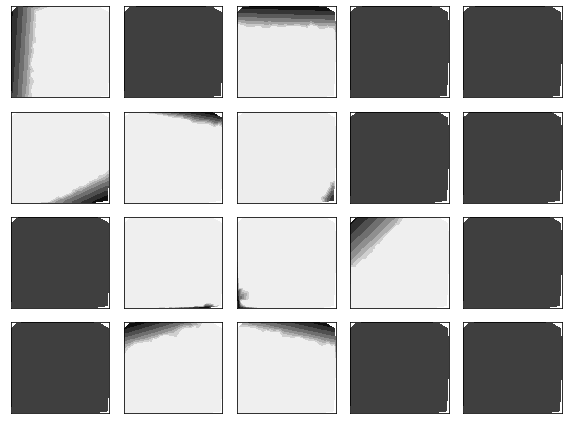

In [ ]:
from srnn_pfc.lmu import make_ldn_B_A
ldn, B_full, A_full = make_ldn_B_A(theta=model_kwargs['theta'], q=model_kwargs['q'],
                                   size_in=2)

x = np.random.uniform(-1, 1, size=(500, 2))
x_converted, a = nengo.utils.ensemble.tuning_curves(model.ensembles[0], sim,
                                                    x @ B_full.T)

plt.figure(figsize=(8,6))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.tricontourf(x[:,0], x[:,1], a[:,i], cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()